#### 참고
- gluon-ts 사이트 : https://gluon-ts.mxnet.io/
- github example : https://github.com/awslabs/gluon-ts
- aws blog : https://aws.amazon.com/ko/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/

In [2]:
!pip install gluonts

     |████████████████████████████████| 419 kB 18.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 82.6 MB/s eta 0:00:01
     |████████████████████████████████| 8.7 MB 79.2 MB/s eta 0:00:01
     |████████████████████████████████| 85 kB 9.6 MB/s s eta 0:00:01
  Created wheel for holidays: filename=holidays-0.9.12-py3-none-any.whl size=47610 sha256=28d9654c42197446179072c2dfce897ac447619152a8f045e489e2f32a8f6ff6
  Stored in directory: /home/ec2-user/.cache/pip/wheels/02/33/ad/d2536fe7f536284398d86acc7bd9fb3d2a9eabbd66050c2e2b
Successfully built holidays
ERROR: autogluon 0.0.11 has requirement pandas<1.0,>=0.24.0, but you'll have pandas 1.0.5 which is incompatible.
  Attempting uninstall: pandas
    Found existing installation: pandas 0.25.3
    Uninstalling pandas-0.25.3:
      Successfully uninstalled pandas-0.25.3
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/mxnet_p36/bin/python -m pip install --upgrade pip' command.


### Dataset load

- sdk : https://gluon-ts.mxnet.io/api/gluonts/gluonts.dataset.common.html

```python
gluonts.dataset.common.ListDataset(
        data_iter: Iterable[Dict[str, Any]],   # Iterable object yielding all items in the dataset.
                                               # Each item should be a dictionary mapping strings to values. 
                                               # For instance: {“start”: “2014-09-07”, “target”: [0.1, 0.2]}.
        freq: str,                             # Frequency of the observation in the time series. Must be a valid Pandas frequency
        one_dim_target: bool = True            # Whether to accept only univariate target time series.
        )

```

In [3]:
from gluonts.dataset import common
import pandas as pd

url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realTweets/Twitter_volume_AMZN.csv"
df = pd.read_csv(url, header=0, index_col=0)
data = common.ListDataset([{"start": df.index[0],
                            "target": df.value[:"2015-04-05 00:00:00"]}],
                          freq="5min")


In [11]:
data.list_data

[{'start': '2015-02-26 21:42:53',
  'target': timestamp
  2015-02-26 21:42:53    57
  2015-02-26 21:47:53    43
  2015-02-26 21:52:53    55
  2015-02-26 21:57:53    64
  2015-02-26 22:02:53    93
                         ..
  2015-04-04 23:37:53    31
  2015-04-04 23:42:53    40
  2015-04-04 23:47:53    44
  2015-04-04 23:52:53    61
  2015-04-04 23:57:53    59
  Name: value, Length: 10684, dtype: int64}]

### Estimator 생성 & training

- sdk : https://gluon-ts.mxnet.io/api/gluonts/gluonts.model.deepar.html

```python
gluonts.model.deepar.DeepAREstimator(
        freq: str, 
        prediction_length: int, 
        trainer: gluonts.trainer._base.Trainer = gluonts.trainer._base.Trainer(epochs=100, learning_rate=0.001, ...), 
        # optional parameters below ----------------
        context_length: Optional[int] = None, 
        num_layers: int = 2, 
        num_cells: int = 40, 
        cell_type: str = 'lstm', 
        dropout_rate: float = 0.1, 
        use_feat_dynamic_real: bool = False, 
        use_feat_static_cat: bool = False, 
        use_feat_static_real: bool = False, 
        cardinality: Optional[List[int]] = None, 
        embedding_dimension: Optional[List[int]] = None, 
        distr_output: gluonts.distribution.distribution_output.DistributionOutput = gluonts.distribution.student_t.StudentTOutput(), 
        scaling: bool = True, lags_seq: Optional[List[int]] = None, 
        time_features: Optional[List[gluonts.time_feature._base.TimeFeature]] = None, 
        num_parallel_samples: int = 100, 
        dtype: gluonts.core.component.DType = <class 'numpy.float32'>
        )

```

In [144]:
from gluonts.model import deepar
from gluonts.trainer import Trainer

trainer = Trainer(epochs=10)
estimator = deepar.DeepAREstimator(
    freq="5min", prediction_length=12, trainer=trainer)
predictor = estimator.train(training_data=data)


  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:05<00:00,  9.60it/s, epoch=10/10, avg_epoch_loss=3.94]


### Prediction



[47.238068 44.287354 40.82398  38.018913 38.088863 37.252586 35.795692
 36.25564  36.559986 37.80865  36.977097 37.34646 ]


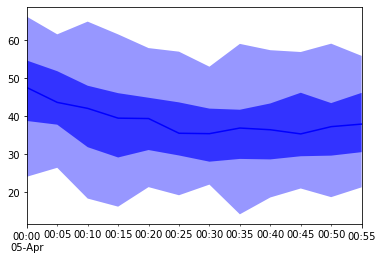

In [145]:
prediction = next(predictor.predict(data))
print(prediction.mean)
prediction.plot()


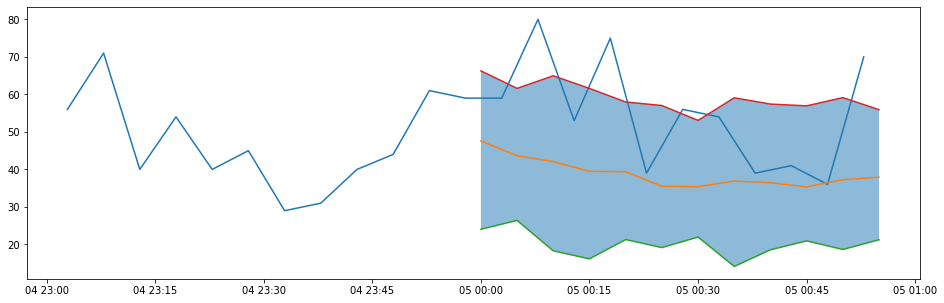

In [146]:
plt.figure(figsize=(16,5))
dfsub = df['2015-04-04 23:00:00':'2015-04-05 00:55:00']
plt.plot(dfsub.reset_index()['timestamp'].astype('datetime64'), dfsub.value.values)
plt.plot(prediction.index, prediction.quantile(0.5))
plt.plot(prediction.index, prediction.quantile(0.05))
plt.plot(prediction.index, prediction.quantile(0.95))
plt.fill_between(prediction.index, prediction.quantile(0.05), prediction.quantile(0.95), alpha=0.5)
plt.show()